## Let's take a look at the dataset from Sherman, Moore, Primeau, Tanouye "Temperature influence on phytoplankton community growth rates" GBC 2016

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.interpolate
import metpy.calc as mpcalc
import math

### Step 1: read the csv into pandas

note: this dataset is exported from Excel to a csv, then preprocessed with the prep_work.sh script that is in the same directory (gets rid of 20 lines of header info which is still in "sherman_growth_mortality_AllData.csv")

In [2]:
csv_file = '/glade/work/kristenk/zooplankton_obs/sherman/sherman_data.csv'
sherman_df = pd.read_csv(csv_file, encoding = "ISO-8859-1")

In [3]:
sherman_df

,G,M,lat,lon,Chl,NO3,Temp,Month,AddNutrients,arctan(G/M),M/G,zone,climate,Region,Final,Notes,Reference
0,0.35,1.04,50.50,-7.00,0.74,-5.00,-5.0,10,1,1.25,2.97,C,T,NorthAtlantic,1.0,NaN,"Burkill et al. 1987, Mar. Biol. 93: 581-590"
1,0.35,0.36,51.60,-4.53,4.69,-5.00,-5.0,10,1,0.80,1.03,C,T,NorthAtlantic,1.0,NaN,"Burkill et al. 1987, Mar. Biol. 93: 581-590"
2,1.00,0.36,41.37,2.21,0.18,-5.00,23.5,9,1,0.35,0.36,C,T,NW Mediterranean,1.0,NaN,"Calbet et al. 2008, Aquat. Microb. Ecol. 50: 1..."
3,0.86,0.38,41.37,2.21,1.54,-5.00,21.5,10,1,0.42,0.44,C,T,NW Mediterranean,1.0,NaN,"Calbet et al. 2008, Aquat. Microb. Ecol. 50: 1..."
4,0.62,0.27,41.37,2.21,0.97,-5.00,16.1,11,1,0.41,0.44,C,T,NW Mediterranean,1.0,NaN,"Calbet et al. 2008, Aquat. Microb. Ecol. 50: 1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,0.33,0.70,30.00,124.00,1.20,1.69,28.5,9,0,1.13,2.12,C,T,Yellow Sea,1.0,NaN,Zhang et al. 2006 Hydrobiologia 553: 357-366
878,0.86,0.66,29.00,127.00,0.25,0.33,28.0,9,0,0.65,0.77,C,T,Yellow Sea,1.0,NaN,Zhang et al. 2006 Hydrobiologia 553: 357-366
879,0.64,0.68,32.00,127.00,4.41,2.98,23.0,9,0,0.82,1.06,C,T,Yellow Sea,1.0,NaN,Zhang et al. 2006 Hydrobiologia 553: 357-366
880,0.68,0.08,31.00,129.00,0.22,0.14,27.0,9,0,0.12,0.12,C,T,Yellow Sea,1.0,NaN,Zhang et al. 2006 Hydrobiologia 553: 357-366


In [4]:
df2 = sherman_df[['lon', 'lat','M']]

In [5]:
df2 = df2[(df2.lat >= -70)] # there a couple of weird microzoo grazing points in Antarctica (must be a mistake), let's take them out

In [6]:
lats = df2.lat
lons = df2.lon
mort = df2.M

### Plot up all data (all months)

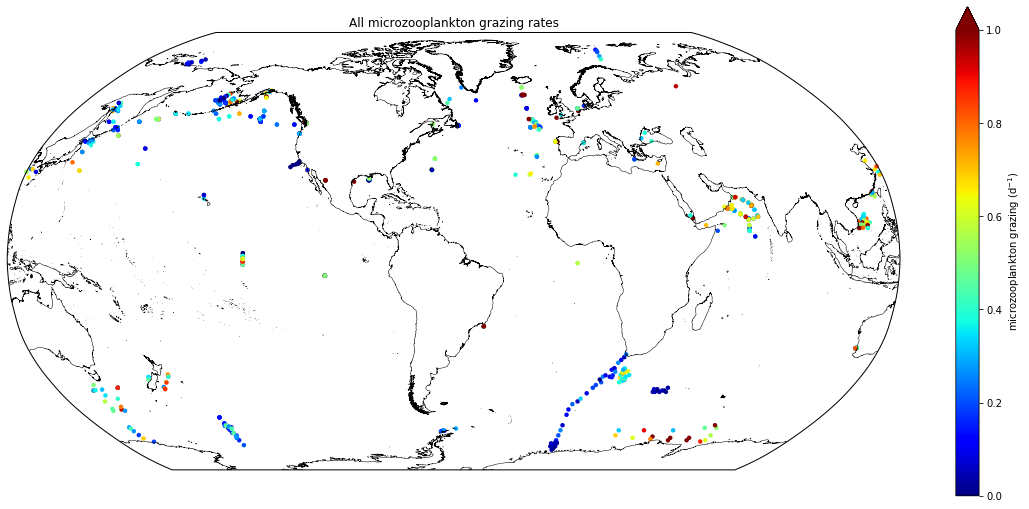

In [7]:
fig = plt.figure(figsize=(20,9))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('All microzooplankton grazing rates', fontsize=12)
ax.coastlines('10m',linewidth=0.5)
sc = ax.scatter(lons,lats, c=mort, vmin=0, vmax =1, cmap='jet', s=20, edgecolors='none', transform=ccrs.PlateCarree())
#pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

cbar = fig.colorbar(sc, ax=ax,extend='max',label='microzooplankton grazing (d$^{-1}$)')

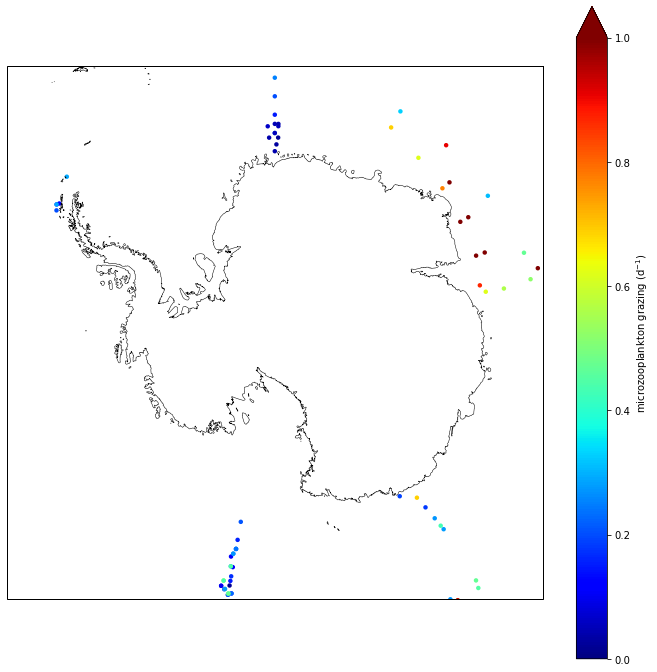

In [8]:
fig = plt.figure(figsize=(12,12))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=0.5)
sc = ax.scatter(lons,lats, c=mort, vmin=0, vmax =1, cmap='jet', s=20, edgecolors='none', transform=ccrs.PlateCarree())
#pc=ax.pcolormesh(lons, lats, most_lim_diat.where(~mask), cmap=plt.cm.get_cmap('Dark2_r',4),vmin=-0.5,vmax=3.5,transform=ccrs.PlateCarree())

cbar = fig.colorbar(sc, ax=ax,extend='max',label='microzooplankton grazing (d$^{-1}$)')

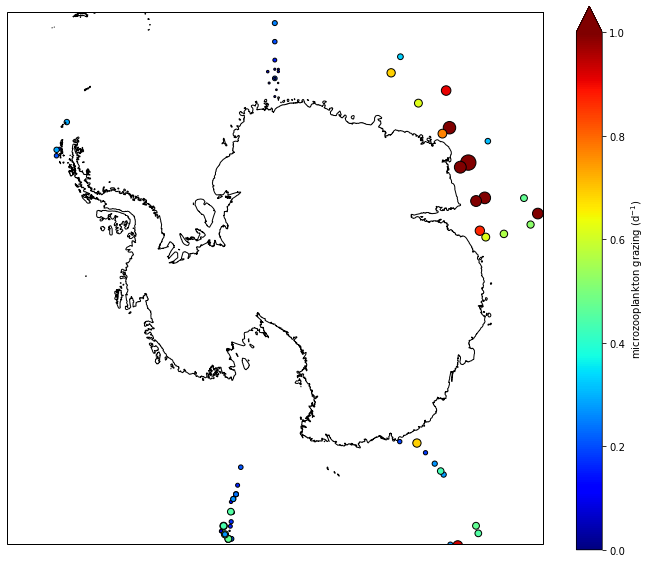

In [13]:
fig = plt.figure(figsize=(12,10))

# obs -----------------------------------------------------------------
ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
ax.coastlines('10m',linewidth=1)
sc = ax.scatter(lons,lats, vmin=0, vmax =1, cmap='jet', 
                s=mort*100, ## size in microzoo grazing rate times 100
                edgecolors='black', 
                c=mort, ## colors are microzoo grazing rate
                transform=ccrs.PlateCarree())

cbar = fig.colorbar(sc, ax=ax,extend='max',label='microzooplankton grazing (d$^{-1}$)')